## TO DO:
- Normalisation of Genblocks so grad passes thru
- Perhaps norm of discrim
- Function to plot better visuals

In [1251]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
from scipy.linalg import sqrtm

In [7]:
ROOT = Path.cwd() / "data" / "mnist"

In [8]:
ROOT

WindowsPath('C:/Stuff/py/projects/ml/ml/data/mnist')

In [1238]:
X_train = np.load(ROOT / "X_train.npy")
X_test = np.load(ROOT / "X_test.npy")
xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd
X_test = (X_test - xmean) / xstd
y_train = np.load(ROOT / "y_train.npy")
y_test = np.load(ROOT / "y_test.npy")

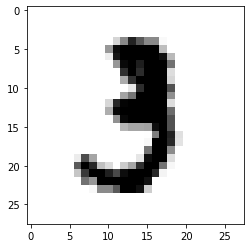

In [852]:
im = X_train[10]
plt.imshow(im, cmap="gray_r")
plt.show()

In [1239]:
X = torch.from_numpy(X_train).view(-1, 1, 28, 28)
y = torch.from_numpy(y_train)
Xt = torch.from_numpy(X_test).view(-1, 1, 28, 28)
yt = torch.from_numpy(y_train)

In [1257]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, stride=1), nn.MaxPool2d(2), nn.ReLU(), nn.Conv2d(4, 8, kernel_size=3, stride=1), nn.MaxPool2d(2), nn.ReLU(), nn.Conv2d(8, 16, kernel_size=3, stride=1), nn.MaxPool2d(2), nn.ReLU(), nn.Flatten())
        self.fc = nn.Linear(16, 10)
        
    def forward(self, x):
        return self.fc(self.convs(x))

In [1258]:
class FD:
    def __init__(self, classifier, X):
        self.classifier = classifier
        self.m, self.sigma = self.get_stats(X)
        
    def get_stats(self, X):
        act = self.classifier.convs(X)
        act = act.detach().numpy()
        m = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return m, sigma
        
    def __call__(self, X):
        m, sigma = self.get_stats(X)
        ssdiff = ((self.m - m)**2.0).sum()
        covmean = sqrtm(self.sigma.dot(sigma))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fd = ssdiff + np.trace(self.sigma + sigma - 2.0 * covmean)
        return fd 

In [1260]:
classifier = Classifier()
fd = FD(classifier, X)

In [1261]:
fd(Xt)

-4.468437609945336e-17

In [1248]:
cls = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, stride=1), nn.MaxPool2d(2), nn.ReLU(), nn.Conv2d(4, 8, kernel_size=3, stride=1), nn.MaxPool2d(2), nn.ReLU(), nn.Conv2d(8, 16, kernel_size=3, stride=1), nn.MaxPool2d(2), nn.ReLU(), nn.Flatten(), nn.Linear(16, 10))
opt = optim.Adam(cls.parameters(), lr=0.001, weight_decay=0.00001)
crit = nn.CrossEntropyLoss()

In [1241]:
cls_trainset = DataLoader(TensorDataset(X, y), batch_size=64, shuffle=True)
cls_testset = DataLoader(TensorDataset(Xt, yt), batch_size=64, shuffle=True)

In [1246]:
def cls_acc(preds, labels):
    size = len(preds)
    p = torch.argmax(preds, axis=1)
    correct = (p == labels).sum().item()
    return correct / size

In [1250]:
for epoch in range(1):
    for x, y in cls_trainset:
        preds = cls(x)
        loss = crit(preds, y)
        acc = cls_acc(preds, y)
        accs.append(acc)
        opt.zero_grad()
        loss.backward()
        opt.step()
    with torch.no_grad():
        accs = []
        for x, y in cls_testset:
            preds = cls(x)
            acc = cls_acc(preds, y)
            accs.append(acc)
    print(f"Epoch: {epoch + 1}, Acc: {np.mean(accs):.5f}")

Epoch: 1, Acc: 0.92632


In [1247]:
cls_acc(preds, y)

0.09916666666666667

In [1184]:
def get_randoms(labels, latent_dim=3, img_dim=32):
    bs = len(labels)
    latent_z = torch.randn((bs, latent_dim))
    noise = torch.randn((bs, img_dim**2))
    return latent_z, noise 

In [1185]:
class LabelEmbed(nn.Module):
    def __init__(self):
        super().__init__()
        self.em = nn.Embedding(10, 1)
        
    def forward(self, x):
        return self.em(x)

In [1186]:
class Generator(nn.Module):
    def __init__(self, latent_dim=3, em_dim=1, size=8):
        super().__init__()
        self.em = LabelEmbed()
        self.gen_block = GenBlock(latent_dim)
        self.gen_syn = GenSyn(latent_dim + em_dim, size)
        
    def forward(self, nums, z_latent, noise):
        em = self.em(nums)
        w_latent = self.gen_block(z_latent)
        w_latent = torch.cat((em, w_latent), axis=1)
        imgs = self.gen_syn(w_latent, noise)
        return imgs
    
    def check(self, nums, z_latent, noise):
        em = self.em(nums)
        w_latent = self.gen_block(z_latent)
        w_latent = torch.cat((em, w_latent), axis=1)
        all_imgs = self.gen_syn.check(w_latent, noise)
        return all_imgs   

In [1187]:
class GenBlock(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(negative_slope=0.2), nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(negative_slope=0.2))
    
    def forward(self, z_latent):
        w_latent = self.net(z_latent)
        return w_latent

In [1205]:
class GenSyn(nn.Module):
    def __init__(self, latent_dim, size=8):
        super().__init__()
        self.size = size
        self.const = Constant(size)
        self.upscale = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.blocks = nn.ModuleList()
        for i in range(7):
            upscale = bool(i % 2)
            self.blocks.append(GenSynBlock(latent_dim, size, upscale))
        self.sig = nn.Sigmoid()

    def forward(self, w_latent, noise):
        combined_imgs = 0
        bs = len(w_latent)
        x = self.const(bs)
        for block in self.blocks:
            x, imgs = block(x, w_latent, noise)
            if hasattr(imgs, "shape"):
                if hasattr(combined_imgs, "shape"):
                    combined_imgs = self.upscale(combined_imgs)
                combined_imgs += imgs
        #return self.sig(combined_imgs)
        return combined_imgs[:, :, :28, :28]
    
    def check(self, w_latent, noise):
        combined_imgs = 0
        bs = len(w_latent)
        x = self.const(bs)
        all_imgs = []
        for block in self.blocks:
            x, imgs = block(x, w_latent, noise)
            if hasattr(imgs, "shape"):
                all_imgs.append(imgs)
        return all_imgs[:, :, :28, :28]

In [1206]:
class Constant(nn.Module):
    def __init__(self, size, img_size=4):
        super().__init__()
        self.const = nn.Parameter(torch.randn(1, size, img_size, img_size))

    def forward(self, bs):
        out = self.const.repeat(bs, 1, 1, 1)
        return out

In [1207]:
class GenSynBlock(nn.Module):
    def __init__(self, latent_dim, size, upscale=True):
        super().__init__()
        self.size = size
        self.upscale = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False) if upscale else None
        self.style_lin = nn.Linear(latent_dim, size)
        self.noise_lin = nn.Linear(1, size)
        self.conv = nn.Conv2d(size, size, kernel_size=3, padding=1)
        self.norm = nn.InstanceNorm2d(size, eps=1e-08)
        self.act = nn.LeakyReLU(negative_slope=0.2)
        self.to_rgb = nn.Conv2d(size, 1, kernel_size=1, padding=0) if not(upscale) else None
        
    def forward(self, x, w_latent, noise):
        # noise: bs x max_img_size ** 2
        # w_latent: bs x latent_dim
        if self.upscale:
            x = self.upscale(x)
        bs, ch, h, w = x.shape
        style = self.style_lin(w_latent)
        x = self.norm(self.conv(x) * style.view(bs, self.size, 1, 1))
        noise = noise[:, : h * w]
        scaled_noise = self.noise_lin(noise.unsqueeze(-1)).permute(0, 2, 1)
        img_noise = scaled_noise.reshape(bs, -1, h, w)
        x = self.act(x) # self.act(x + img_noise)
        if self.to_rgb:
            imgs = self.to_rgb(x)
        else:
            imgs = 0
        return x, imgs

In [1208]:
class Discriminator(nn.Module):
    def __init__(self, sizes=None, final_size=None):
        super().__init__()
        layers = []
        self.em = LabelEmbed()
        if not sizes:
            sizes = [(1, 4), (4, 4), (4, 4)]
            final_size = 64
        for n_in, n_out in sizes:
            layers.append(ResBlock(n_in, n_out))
        layers.append(nn.Flatten())
        self.net = nn.Sequential(*layers)
        self.fc = nn.Linear(final_size + 1, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, nums):
        em = self.em(nums)
        x = self.net(x)
        x = torch.cat((x, em), axis=1)
        return self.sig(self.fc(x))

In [1209]:
class ResBlock(nn.Module):
    def __init__(self, n_filters_in, n_filters_out):
        super().__init__()
        self.conv1 = nn.Conv2d(n_filters_in, n_filters_out, kernel_size=3, padding=1, stride=1)
        self.act1 = nn.LeakyReLU(negative_slope=0.2)
        self.conv2 = nn.Conv2d(n_filters_out, n_filters_out, kernel_size=3, padding=1, stride=2)
        self.act2 = nn.LeakyReLU(negative_slope=0.2)
        self.convs = nn.Sequential(self.conv1, self.act1, self.conv2, self.act2)
        self.down = nn.Conv2d(n_filters_in, n_filters_out, kernel_size=1, padding=0, stride=2)
        
    def forward(self, x):
        conv_x = self.convs(x)
        down_x = self.down(x)
        return conv_x + down_x

In [1210]:
def set_requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [1211]:
def discrim_loss(true_preds, fake_preds):
    return (-(torch.log(true_preds) + torch.log(1 - fake_preds))).mean()

In [1212]:
def gen_loss(fake_preds):
    return (-torch.log(fake_preds)).mean()

In [1213]:
def accuracy(fake_preds):
    return ((fake_preds < 0.5).sum() / float(len(fake_preds)))

In [ ]:
def calculate_fd(act1, act2):
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = ((mu1 - mu2)**2.0).sum()
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fd

In [1214]:
def train_epoch(loader, gen, em, discrim, g_crit, d_crit, g_opt, d_opt):
    d_losses = []
    d_accs = []
    g_losses = []
    grads = []
    for o, (true_imgs, labels) in enumerate(loader):
        if (o % 2):
            g_loss, grad = train_gen(true_imgs, labels, gen, discrim, g_crit, g_opt)
            g_losses.append(g_loss)
            grads.append(grad)
        else:
            d_loss, d_acc = train_discrim(true_imgs, labels, gen, discrim, d_crit, d_opt)
            d_losses.append(d_loss)
            d_accs.append(d_acc)
    return np.mean(d_losses), np.mean(d_accs), np.mean(g_losses), grads

In [1215]:
def train_discrim(true_imgs, labels, gen, discrim, d_crit, d_opt):
    set_requires_grad(gen, False)
    set_requires_grad(discrim, True)
    z_latent, noise = get_randoms(labels)
    fake_imgs = gen(labels, z_latent, noise)
    fake_preds = discrim(fake_imgs, labels)
    true_preds = discrim(true_imgs, labels)
    loss = d_crit(true_preds, fake_preds)
    acc = accuracy(fake_preds)
    d_opt.zero_grad()
    loss.backward()
    d_opt.step()
    return loss.item(), acc.item()

In [1216]:
def train_gen(true_imgs, labels, gen, discrim, g_crit, g_opt):
    set_requires_grad(gen, True)
    set_requires_grad(discrim, False)
    z_latent, noise  = get_randoms(labels)
    fake_imgs = gen(labels, z_latent, noise)
    fake_preds = discrim(fake_imgs, labels)
    loss = g_crit(fake_preds)
    g_opt.zero_grad()
    loss.backward()
    grads = []
    for block in gen.gen_syn.blocks:
        grads.append(block.conv.weight.grad.abs().mean().item())
    g_opt.step()
    return loss.item(), grads

In [1217]:
size=1000
train_set = DataLoader(TensorDataset(X[:size], y[:size]), batch_size=64, shuffle=True) 

In [1224]:
gen = Generator()
discrim = Discriminator()
g_crit = gen_loss
d_crit = discrim_loss
g_opt = optim.Adam(gen.parameters(), lr=0.001)
d_opt = optim.Adam(discrim.parameters(), lr=0.001, weight_decay=0.0)

In [1225]:
for i in range(100):
    dloss, dacc, gloss, grads = train_epoch(train_set, gen, em, discrim, g_crit, d_crit, g_opt, d_opt)
    print(f"{dloss:.5f}, {dacc:.2f}, {gloss:.5f}")

1.42788, 1.00, 0.81781
1.43329, 0.49, 0.69129
1.43884, 0.05, 0.64870
1.43256, 0.03, 0.64739
1.41585, 0.13, 0.67371
1.40457, 0.56, 0.69800
1.40969, 0.59, 0.70178
1.41139, 0.74, 0.70607
1.40088, 0.84, 0.71528
1.38716, 0.89, 0.71329
1.38772, 0.56, 0.69502
1.38315, 0.21, 0.69206
1.38933, 0.49, 0.69781
1.39451, 0.36, 0.69375
1.38577, 0.11, 0.68514
1.37833, 0.10, 0.67921
1.39456, 0.10, 0.67680
1.37969, 0.85, 0.74670
1.35069, 1.00, 0.83071
1.39411, 0.49, 0.69301
1.38113, 0.03, 0.65353
1.40782, 0.14, 0.67453
1.38569, 0.23, 0.69161
1.38957, 0.98, 0.76474
1.36689, 0.91, 0.75508
1.35840, 0.98, 0.76460
1.32284, 0.63, 0.71363
1.20119, 0.94, 0.84343
1.21140, 0.82, 0.98878
1.43745, 0.71, 1.04501
1.45534, 0.54, 0.86823
1.38114, 0.33, 0.77968
0.93964, 0.97, 1.18651
0.94056, 0.81, 1.37627
0.94156, 0.87, 1.85134
0.53886, 1.00, 2.08971
0.82277, 0.78, 1.63208
0.92648, 0.85, 1.45652
0.63910, 0.94, 1.83630
0.92190, 0.88, 1.83060
0.82956, 0.92, 1.75396
1.14320, 0.76, 1.32983
1.21415, 0.54, 1.40855
0.99758, 0.

In [1154]:
def show_examples(gen, dl):
    x_b, y_b = next(iter(dl))
    z_latent, noise = get_randoms(y_b)
    fake_imgs = gen(y_b, z_latent, noise)
    mix_imgs = torch.cat((fake_imgs[:8], x_b[:8]))
    fig, axs = plt.subplots(4, 4, figsize=(15, 8))
    i = 0
    for row in axs:
        for col in row:
            col.imshow(mix_imgs[i,0].detach().numpy(), cmap="gray_r")
            i += 1
    plt.show()

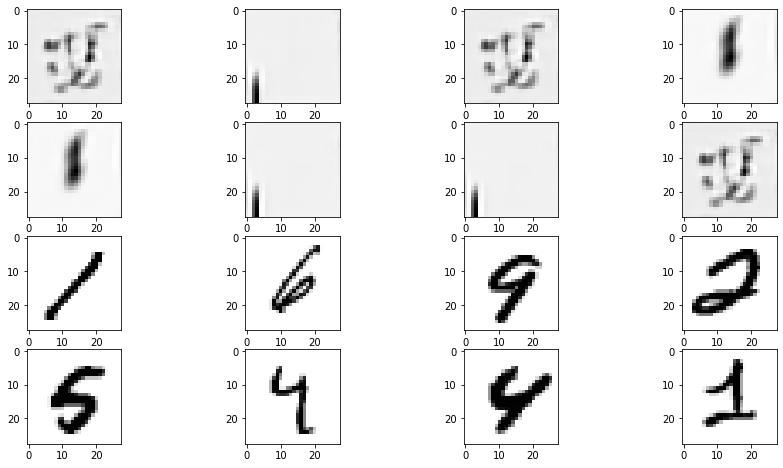

In [1226]:
show_examples(gen, train_set)

In [1221]:
x_b, y_b = next(iter(train_set))
z_latent, noise = get_randoms(y_b)
fake_imgs = gen(y_b, z_latent, noise)
preds = discrim(fake_imgs, y_b)
print(accuracy(preds))

tensor(0.3281)


In [1223]:
x_b, y_b = next(iter(train_set))
z_latent, noise = get_randoms(y_b)
all_imgs = gen.check(y_b, z_latent, noise)
first_im = [im[0] for im in all_imgs]

TypeError: list indices must be integers or slices, not tuple

In [1160]:
print(y_b)

tensor([9, 0, 7, 3, 0, 8, 8, 2, 1, 0, 9, 5, 7, 7, 5, 5, 8, 1, 9, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 2, 1, 3, 5, 6, 2, 6, 4, 9, 5, 1, 3, 7, 6, 5, 3, 4, 5, 3, 1,
        6, 1, 3, 9, 4, 4, 6, 5, 3, 1, 7, 2, 1, 9, 3, 9])


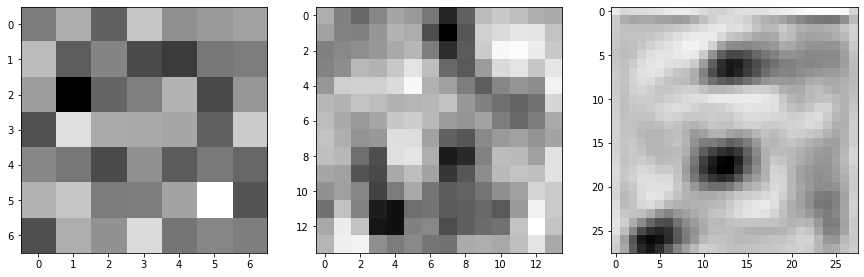

In [1161]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
for ax, im in zip(axs,first_im): 
    ax.imshow(im.detach().numpy()[0], cmap="gray_r")
plt.show()

In [1162]:
upper = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

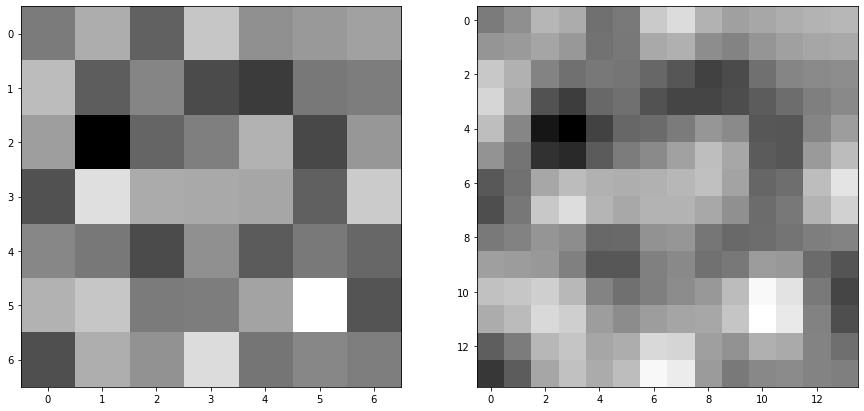

In [1163]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(first_im[0].detach().numpy()[0], cmap="gray_r")
axs[1].imshow(upper(first_im[0].unsqueeze(0))[0].detach().numpy()[0], cmap="gray_r")
plt.show()

In [1098]:
t = torch.randn((10, 3, 32, 32))

In [1116]:
s = torch.ones((10, 3))
s[:,1] = 2

In [1118]:
g = t * s.expand(size=(10, 3, 1))

RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 2.  Target sizes: [10, 3, 1].  Tensor sizes: [10, 3]

In [1115]:
g.shape

torch.Size([10, 3, 32, 32])

In [1114]:
t == g

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [1106]:
t.sha

tensor([[[[-4.0929e-01, -1.3162e+00, -2.0179e-01,  ..., -6.9764e-02,
            4.0544e-01,  1.3710e-01],
          [-7.6128e-01,  8.2998e-01,  3.8887e-01,  ...,  1.7311e+00,
            7.7210e-01,  7.2054e-01],
          [ 6.5544e-01, -1.4520e-01,  1.5470e+00,  ..., -3.1585e-01,
           -2.3624e+00, -7.5837e-01],
          ...,
          [ 5.7434e-01, -4.9521e-01,  1.0517e+00,  ...,  1.1239e+00,
            1.7736e-01,  8.0645e-01],
          [ 9.2122e-01,  5.5226e-01, -1.3639e-04,  ...,  4.4657e-01,
           -1.8893e+00,  1.8126e-01],
          [-1.5400e+00, -1.2934e-02,  1.1879e+00,  ...,  2.0407e+00,
           -1.2810e+00,  9.5667e-02]],

         [[-9.2727e-01,  4.5355e-01, -1.0870e-01,  ...,  1.1492e+00,
            1.1288e+00, -1.8394e-01],
          [-1.3682e+00,  1.2663e+00, -2.6751e-01,  ...,  1.1390e+00,
            1.8434e-01,  5.1054e-01],
          [ 6.3531e-01,  6.2805e-01,  4.6577e-02,  ..., -1.6834e+00,
           -2.2813e-01, -5.2620e-01],
          ...,
     

In [1167]:
gen.gen_syn.const.const[0]

tensor([[[-1.2824, -1.1515,  0.2040,  0.2154,  0.6724, -1.3465,  0.8451],
         [-0.7576, -0.8147,  0.5783, -0.2726,  0.1059,  1.0993, -0.7232],
         [-1.1811,  1.4979,  0.0505, -0.6839, -1.6553,  0.4173,  1.2472],
         [-0.0887, -0.2930,  1.5443,  1.5407,  0.3840, -1.8406, -1.8980],
         [-1.6285,  0.8944, -0.4011, -0.4273,  0.9606,  0.3991, -1.0077],
         [ 2.2027, -1.3321,  1.1103, -0.6333,  0.7833,  0.2430,  1.6501],
         [-0.6011, -0.3970,  0.5980, -0.3041,  0.5433, -0.1577,  0.3007]],

        [[-1.3175,  0.8946,  1.3681,  1.2289, -0.1596,  0.6348,  0.4605],
         [-1.0862, -0.3635, -0.5049,  1.1388,  0.5428, -1.4256,  1.5418],
         [ 0.3199, -0.9007,  0.4731, -0.3219, -0.6034,  0.4352, -1.1254],
         [-0.4074, -1.0506, -0.1438,  0.9388,  0.2324, -0.2455,  0.7871],
         [-0.2678, -0.1953,  2.3093,  0.5210,  1.5199, -0.9906,  0.7387],
         [ 2.7954,  0.7162, -0.3940,  0.1398, -1.6866,  0.7644, -1.1658],
         [-0.4124,  0.6697, -0.9622,